In [1]:
# Import the drive module from google.colab to access Google Drive files.
# Mount Google Drive to the '/content/drive' directory to allow access to datasets stored there.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install tensorflow


In [3]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
!cp -r "/content/drive/MyDrive/ai_ml_datasets/plantvillage dataset/potato_dataset" /content/potato_dataset


In [5]:
# Import TensorFlow for building and training machine learning models.
import tensorflow as tf
# Import the models and layers submodules from TensorFlow Keras for defining neural network architecture.
from tensorflow.keras import models,layers
# Import matplotlib.pyplot for plotting and visualization.
import matplotlib.pyplot as plt

In [6]:
# Define BATCH_SIZE for the number of samples per gradient update.
BATCH_SIZE=32
# Define IMAGE_SIZE for resizing input images to a consistent dimension.
IMAGE_SIZE=256
# Define CHANNELS for the number of color channels in the images (e.g., 3 for RGB).
CHANNELS=3
# Define EPOCHS for the number of complete passes through the training dataset.
EPOCHS=50

In [7]:
# Load the image dataset from the specified directory.
# tf.keras.preprocessing.image_dataset_from_directory is used for efficient loading of images.
# '/content/drive/MyDrive/ai_ml_datasets/plantvillage dataset/color' is the path to the dataset.
# seed=123 ensures reproducibility of the dataset shuffling.
# shuffle=True shuffles the order of the images.
# image_size=(IMAGE_SIZE,IMAGE_SIZE) resizes all images to the predefined IMAGE_SIZE.
# batch_size=BATCH_SIZE specifies the number of images in each batch.
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/potato_dataset/",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 2152 files belonging to 3 classes.


In [8]:
# Extract the class names (directory names) from the loaded dataset.
class_names=dataset.class_names
# Print the retrieved class names to verify them.
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


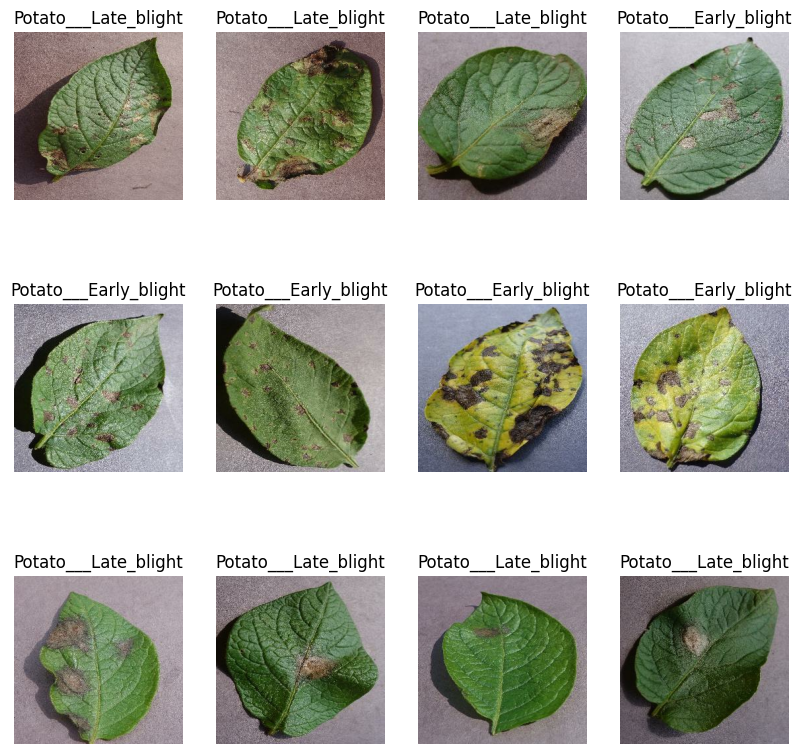

In [9]:
plt.figure(figsize=(10,10))
# Iterate through the first batch of images from the dataset.

# Take one batch from the dataset to inspect its structure and content.
# This helps in understanding the shape of the image tensor and the labels.
for image_batch,labels_batch in dataset.take(1):
  # Print the shape of the image batch (e.g., (batch_size, image_height, image_width, channels)).
  print(image_batch.shape)
  # Print the labels of the images in the batch, converted to a NumPy array.
  print(labels_batch.numpy())
  for i in range(12):
    # Create a 3x4 grid of subplots to display images.
    plt.subplot(3,4,i+1)
    # Display the i-th image from the batch.
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    # Set the title of the subplot to the corresponding class name.
    plt.title(class_names[labels_batch[i]])


    plt.title(class_names[labels_batch[i]])
    # Turn off the axis labels for better visualization.
    plt.axis('off')



### 80% --> Training

### 20% --> test

10 --> Validation,
10% --> Test

In [10]:
# train_size=0.8
# train_ds=dataset.take(int(train_size*len(dataset)))
# test_ds=dataset.skip(int(train_size*len(dataset)))


In [11]:
# val_size=0.1
# val_ds=dataset.take(int(val_size*len(dataset)))
# test_ds=dataset.skip(int(val_size*len(dataset)))

In [12]:
def get_dataset_partition_tf(
    ds,
    train_split=0.8,
    val_split=0.1,
    test_split=0.1,
    shuffle=True,
    shuffle_size=1000   # REDUCED
):
    assert (train_split + val_split + test_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size   = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds   = ds.skip(train_size).take(val_size)
    test_ds  = ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds


In [13]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)


In [14]:
len(train_ds)

54

In [15]:
len(val_ds)

6

In [16]:
len(test_ds)

8

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache("/tmp/train_cache").prefetch(AUTOTUNE)
val_ds   = val_ds.cache("/tmp/val_cache").prefetch(AUTOTUNE)
test_ds  = test_ds.cache("/tmp/test_cache").prefetch(AUTOTUNE)


In [18]:
from tensorflow.keras import layers

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255)
])


In [19]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])


In [20]:
n_classes=len(class_names)
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])
model.build(input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [24]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 286ms/step - accuracy: 0.4820 - loss: 0.9550 - val_accuracy: 0.5677 - val_loss: 0.8259
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.5998 - loss: 0.7659 - val_accuracy: 0.6979 - val_loss: 0.6503
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.7639 - loss: 0.5674 - val_accuracy: 0.7292 - val_loss: 0.5688
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.8289 - loss: 0.4155 - val_accuracy: 0.9271 - val_loss: 0.3055
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.8561 - loss: 0.3796 - val_accuracy: 0.9688 - val_loss: 0.0834
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.9267 - loss: 0.1585 - val_accuracy: 0.7812 - val_loss: 0.4556
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.8891 - loss: 0.2457 - val_accuracy: 0.9688 - val_loss: 0.0871
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.9461 - loss: 0.1530 - val_accuracy: 0.9375 -

In [25]:
len(test_ds)

8

In [26]:
scores=model.evaluate(test_ds)
scores

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step - accuracy: 0.9965 - loss: 0.0099


[0.016152217984199524, 0.9921875]

In [27]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [28]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [29]:
history.history['accuracy']

[0.48495370149612427,
 0.6568287014961243,
 0.7853009104728699,
 0.8825231194496155,
 0.8993055820465088,
 0.8842592835426331,
 0.9236111044883728,
 0.9537037014961243,
 0.9554398059844971,
 0.9722222089767456,
 0.9745370149612427,
 0.9780092835426331,
 0.9756944179534912,
 0.9519675970077515,
 0.9693287014961243,
 0.9710648059844971,
 0.9693287014961243,
 0.9565972089767456,
 0.9577546119689941,
 0.9855324029922485,
 0.9878472089767456,
 0.9890046119689941,
 0.9866898059844971,
 0.9878472089767456,
 0.9907407164573669,
 0.9895833134651184,
 0.9710648059844971,
 0.9913194179534912,
 0.9866898059844971,
 0.9820601940155029,
 0.9913194179534912,
 0.9942129850387573,
 0.9965277910232544,
 0.9930555820465088,
 0.9947916865348816,
 0.9982638955116272,
 0.9785879850387573,
 0.9936342835426331,
 0.9971064925193787,
 0.9785879850387573,
 0.9693287014961243,
 0.9924768805503845,
 0.9751157164573669,
 0.9924768805503845,
 0.9959490895271301,
 0.9780092835426331,
 0.9681712985038757,
 0.989004611

In [30]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

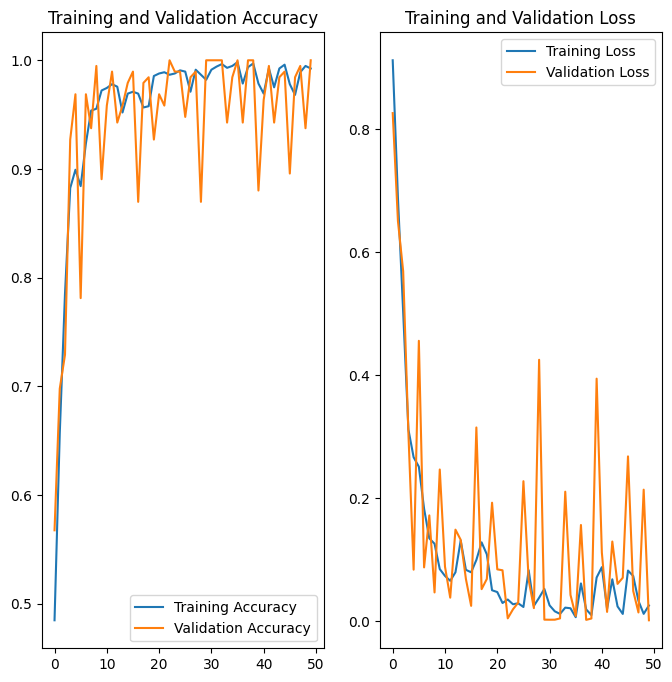

In [31]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
predicted label: Potato___Early_blight


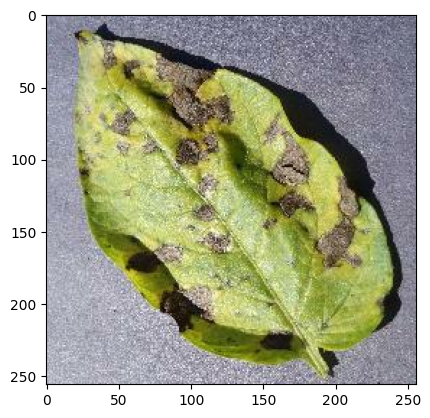

In [32]:
for images_batch,labels_batch in test_ds.take(1):
  first_image=images_batch[0].numpy().astype('uint8')
  first_label=labels_batch[0].numpy()

  print('first image to predict')
  plt.imshow(first_image)
  print('actual label:',class_names[first_label])

  batch_prediction=model.predict(images_batch)
  print('predicted label:',class_names[tf.math.argmax(batch_prediction[0])])

In [33]:
def predict(model, img):
    img_array = tf.expand_dims(img, 0)  # shape: (1, H, W, C)
    predictions = model.predict(img_array, verbose=0)

    predicted_class = class_names[tf.argmax(predictions[0]).numpy()]
    confidence = round(100 * tf.reduce_max(predictions[0]).numpy(), 2)

    return predicted_class, confidence


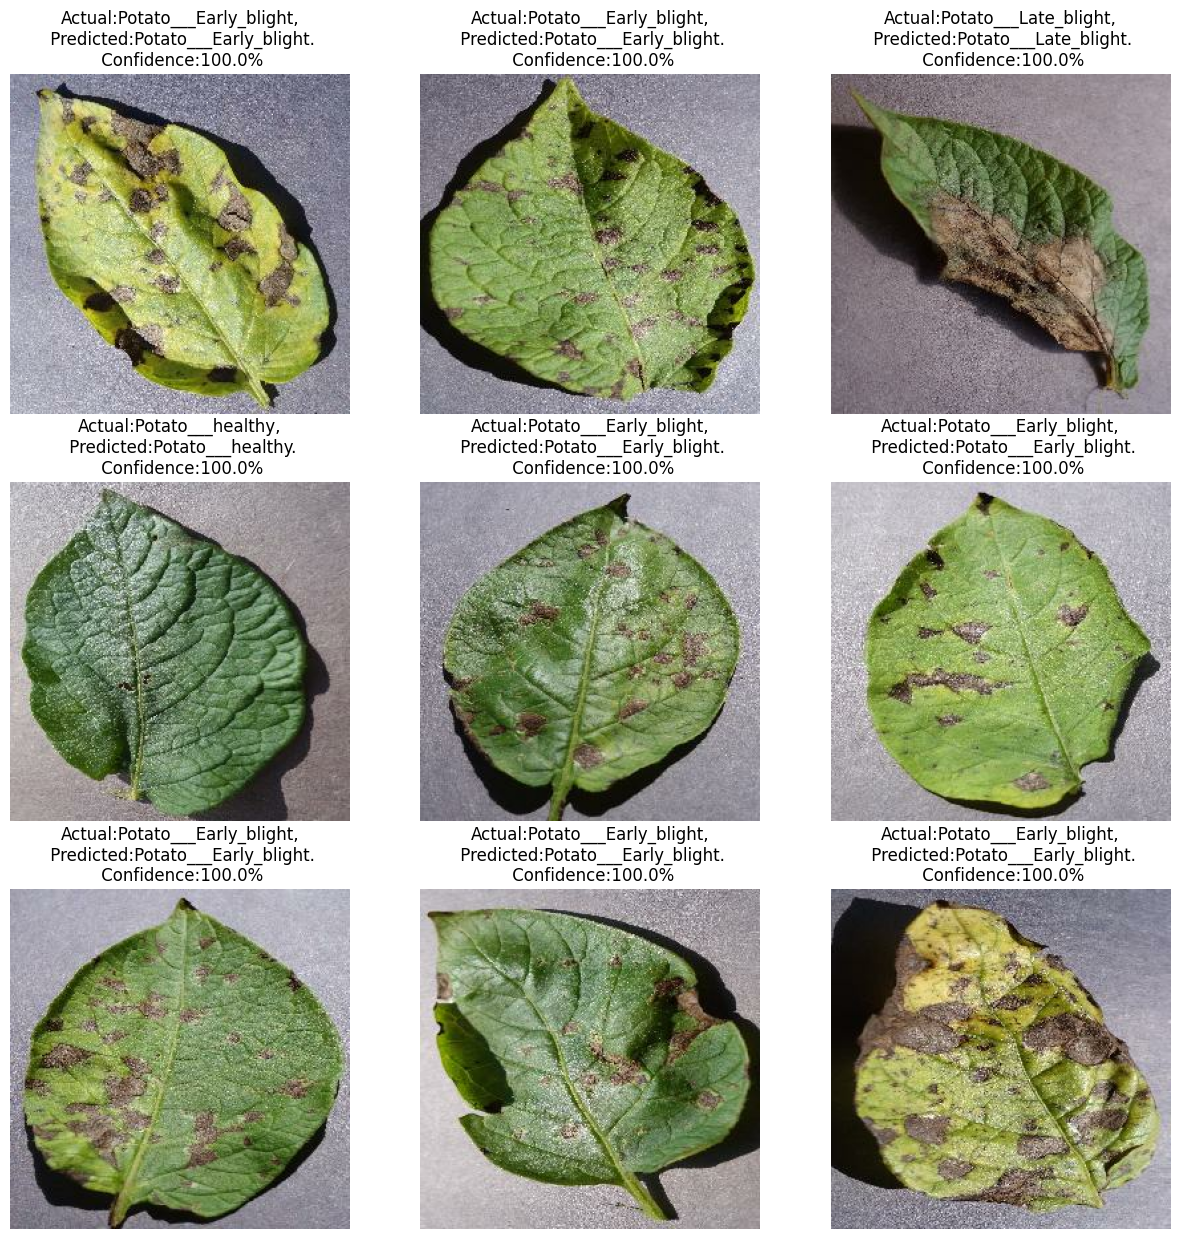

In [34]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))

    predicted_class,confidence=predict(model,images[i].numpy())

    actual_class=class_names[labels[i]]
    plt.title(f"Actual:{actual_class},\n Predicted:{predicted_class}.\n Confidence:{confidence}%")

    plt.axis('off')



### Saving the model

In [36]:
model.save(
    "/content/drive/MyDrive/ai_ml_datasets/plantvillage dataset/models/potato_disease_detection_model.h5"
)

# Serialize model to json
model_json = model.to_json()

# Save the model architecture to JSON file
with open("/content/drive/MyDrive/ai_ml_datasets/plantvillage dataset/models/potato_disease_detection_model.json", "w") as json_file:
    json_file.write(model_json)

# Saving the weights of the model
model.save_weights("/content/drive/MyDrive/ai_ml_datasets/plantvillage dataset/models/potato_disease_detection_model_weights.weights.h5")